Few changes plannig to do from previous code
1.F_S converting as object
2.Gaining insights from data with a subsample
3.New features/feature transformations

In [56]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
import xgboost 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc
#from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#from sklearn.ensemble import RandomForestClassifier
import pickle

In [57]:
os.getcwd()
os.chdir('/Users/padmac/desktop/dspython/project')
df_bkp=pd.read_csv("CST_level_Data.csv",date_parser=['A_O_DT'])
df=pd.read_csv("CST_level_Data.csv",date_parser=['A_O_DT'])
df.info()
df.shape
print(df.head())
df.columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 1','Unnamed: 10','F_IN','ACCOUNT_NB'],inplace=True,errors='ignore')
obj=df.describe(include='object')

/Users/padmac/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (6,7,11,12,15,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178523 entries, 0 to 178522
Data columns (total 34 columns):
Unnamed: 0         178523 non-null int64
Unnamed: 1         0 non-null float64
A_O_DT             178523 non-null object
ACCOUNT_NB         178523 non-null int64
ASSET_LEVEL        158832 non-null object
EDUCATION_LEVEL    162152 non-null float64
AGE                178523 non-null object
I_LM               178523 non-null object
F_IN               0 non-null float64
F_S                178523 non-null int64
Unnamed: 10        0 non-null float64
A1_LM              178523 non-null object
A2_LM              178523 non-null object
A3_LM              178523 non-null int64
A4_LM              178523 non-null float64
A5_LM              178523 non-null object
A6_LM              178523 non-null float64
A7_LM              178522 non-null float64
A8_LM              178523 non-null int64
A9_LM              178523 non-null float64
A10_LM             178523 non-null float64
A11_LM            

In [58]:
df['A_O_DT']=pd.to_datetime(df['A_O_DT'],errors='raise',yearfirst=True,format='%m/%d/%Y')
df=df.sort_values(by='A_O_DT').reset_index(drop=True)




Let's see the distribution of data in terms of account opening date.

<BarContainer object of 12 artists>

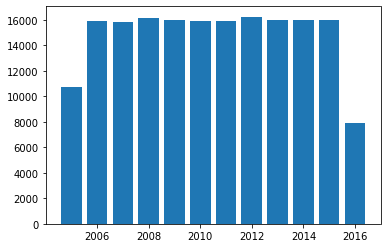

In [59]:
#to find the distribution on account opening date
yearcount=dict()

for row in df.iterrows():
    year_c=row[1][0].year
    yearcount[year_c] = yearcount.get(year_c,0) + 1
plt.bar(yearcount.keys(),list(yearcount.values()))


It looks like most the of the account holders in the sample selected are from 2012. Most account holders started account from 2006 to 2015

In [60]:
df['AGE']=df['AGE'].apply(lambda x: np.where((x=='#NAME?'),np.NaN,x))
df['AGE']=df['AGE'].astype(float)
df['AGE'].isnull().sum()
df['AGE']=df['AGE'].abs()
#df['ASSET_LEVEL']
df['ASSET_LEVEL'].value_counts()
#replacing '?' with NaN. All NaN can be handled later
df['ASSET_LEVEL']=df.apply(lambda x: np.NaN if x['ASSET_LEVEL']=='?' else x['ASSET_LEVEL'],axis=1)

#change I_LM to int
#fails as one field contains comma eg: 642,235 in 14th row
df['I_LM']=df['I_LM'].astype(str).str.replace(',','',regex=False).astype(float)

#A1_LM
df['A1_LM'].unique()
df['A1_LM'].isnull().sum()
df['A1_LM']=df['A1_LM'].astype(str).str.replace(',','',regex=False).astype(float)
#A2_LM.cant covert object to int as words are present
#column contains numbers in words like 3 lac 50 thsnd
df['A2_LM'].unique()
df['A2_LM'].isnull().sum()
df['A2_LM']=df.apply(lambda x: '350000' if x['A2_LM']=='3 lac 50 thsnd' else x['A2_LM'],axis=1)
df['A2_LM']=df['A2_LM'].astype(int)

#'A5_LM'
df['A5_LM']=df.apply(lambda x: '70022' if x['A5_LM']=='seventy thsnd 22' else x['A5_LM'],axis=1)
df['A5_LM']=df['A5_LM'].astype(int)
#df['A12_LM']
df['A12_LM']=df['A12_LM'].astype(str).str.replace(',','',regex=False).astype(float)

#df['A14_LM'].thiscolumn has comma and Nan,as NaN is float converting column as float
#converting an interger might be a problem when the column is an identifier
df['A14_LM']=df['A14_LM'].astype(str).str.replace(',','',regex=False).astype(float)

#df['Y/N'].making all letters capital case.
df['Y/N']=df['Y/N'].str.upper()
##fromvalue_counts N has 169467 and Y has 9056 entries
df['EDUCATION_LEVEL']=df['EDUCATION_LEVEL'].astype(object)


df['F_S']=df['F_S'].astype('object')

In [61]:
df.loc[df['AGE']>100]

,A_O_DT,ASSET_LEVEL,EDUCATION_LEVEL,AGE,I_LM,F_S,A1_LM,A2_LM,A3_LM,A4_LM,...,A14_LM,A15_LM,A16_LM,A17_LM,A18_LM,RATING_Q1,RATING_Q2,RATING_Q3,RATING_Q4,Y/N
13259,2006-02-27,T,63,1187.0,629385.0,5,120182.0,102634,62169,194685.0,...,168734.0,70740.0,228361.0,246893.0,251002.0,NaN,NaN,3,0,N
129706,2013-06-08,M,105,818.0,453749.0,9,89043.0,175334,135064,120256.0,...,126494.0,253044.0,29077.0,49321.0,21044.0,6,3,S,S,N


There are few rows with age value more than 100 (2 observations).Looks like they denote months.

In [62]:
df['AGE']=df.apply(lambda x: x['AGE']/12  if x['AGE']>100 else x['AGE'],axis=1)
df.set_index('A_O_DT',inplace=True)
df['AOD_day']=df.index.day
df['AOD_mon']=df.index.month
df['AOD_year']=df.index.year
df['age_binned']=pd.cut(df.AGE,bins=[0,31,56,76,100],labels=['young','middle','elder','oldest'],include_lowest=True)


Dropping NaN rows and thus reducing the number of observations for easy analysis and visualization of data.

Binning age for getting more insights!

age_binned
young     16127
middle    12754
elder     10564
oldest    12333
Name: age_binned, dtype: int64


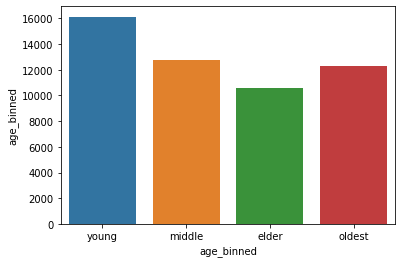

In [63]:
dfi=df.copy()
dfi.dropna(inplace=True)
sns.barplot(x=dfi.groupby(by='age_binned').age_binned.count().index,y=dfi.groupby(by='age_binned').age_binned.count())
print(dfi.groupby(by='age_binned').age_binned.count())

Data set contains more of young age group.young > middle > oldest > elder.Now we will see how this influences the target variable.

young     16127
middle    12754
elder     10564
oldest    12333
Name: age_binned, dtype: int64

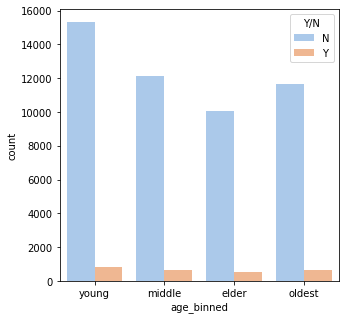

In [64]:
plt.figure(figsize=(5,5))
sns.countplot(x=dfi.age_binned,hue=dfi['Y/N'],palette='pastel')
dfi.age_binned.value_counts()
dfi[dfi['Y/N']=='Y'].groupby(by='age_binned').age_binned.count()
dfi[dfi['Y/N']=='N'].groupby(by='age_binned').age_binned.count()
dfi.age_binned.value_counts(sort=False)



In [89]:
dfi.EDUCATION_LEVEL.value_counts()

58.0     5261
42.0     5257
4.0      5222
105.0    5215
5.0      5213
195.0    5167
63.0     5160
83.0     5153
31.0     5071
47.0     5059
Name: EDUCATION_LEVEL, dtype: int64

,ycount,ncount,total,yperc,catperc
age_binned,,,,,
young,808,15319,16127,5.010231,31.146433
middle,638,12116,12754,5.002352,24.632083
elder,514,10050,10564,4.865581,20.402488
oldest,664,11669,12333,5.383929,23.818996


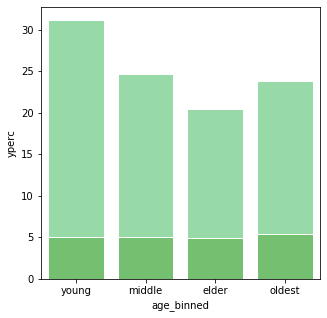

In [68]:
age_perc=pd.DataFrame({'ycount': list(dfi[dfi['Y/N']=='Y'].groupby(by='age_binned').age_binned.count().values),
             'ncount': list( dfi[dfi['Y/N']=='N'].groupby(by='age_binned').age_binned.count().values),
              'total':list(dfi.age_binned.value_counts(sort=False).values)},index=dfi[dfi['Y/N']=='N'].groupby(by='age_binned').age_binned.count().index)

age_perc['yperc']=(age_perc['ycount']*100)/(age_perc['total'])
age_perc['catperc']=(age_perc['total']*100)/(np.sum(age_perc['total']))

fig,ax = plt.subplots(figsize=(5,5))
sns.set_color_codes(palette='pastel') 
sns.barplot(x=age_perc.index,y=age_perc.catperc,color='g',edgecolor='w',label='totalpercentage')
sns.set_color_codes(palette='muted')
sns.barplot(x=age_perc.index,y=age_perc.yperc,color='g',edgecolor='w',label='ypercentage')
plt.show
age_perc


Binning as follows,
0-29--> young, 30-55--> middle, 56-75--> elder, 76-100-->oldest
From the figures of percentages(yperc) for account holder respoding as Y,oldest group tend to prefer the product more.Elder people tends to reject the product.But it's quite interesting to note that the oldest bunch is accepting the product.Is it because the older group having more money/saving? Also does young group accepting because of their spending rate? Well agin it also depends on the type of product that the company is launching.

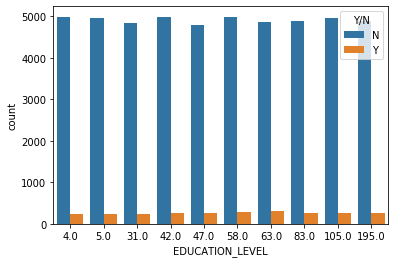

In [69]:
#Check the distribution of the feature EDUCATION_LEVEL
sns.countplot(x=dfi.EDUCATION_LEVEL,hue=dfi['Y/N'])


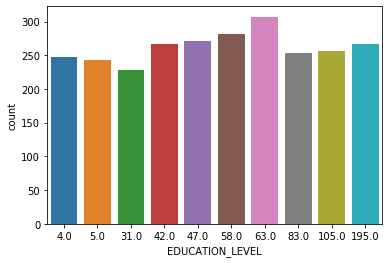

In [71]:
sns.countplot(x=dfi[dfi['Y/N']=='Y'].EDUCATION_LEVEL)

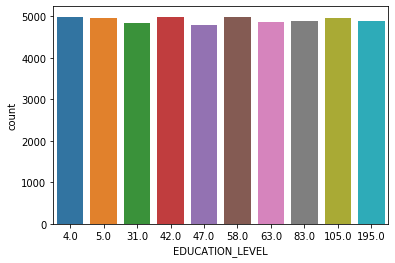

In [72]:
sns.countplot(x=dfi[dfi['Y/N']=='N'].EDUCATION_LEVEL)

Education level 63, more likely to respond as Y. People from all education levels tend to reject the project, with high number of rejections from level 42 and 58.

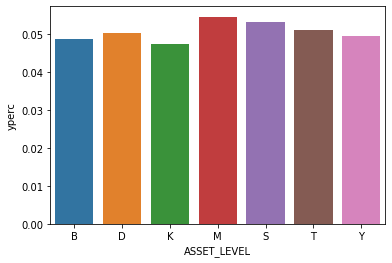

In [73]:
#Finding Relation of Asset level with target variable
dfiast=dfi.groupby(by=['ASSET_LEVEL','Y/N']).ASSET_LEVEL.count()
dfiast=dfiast.unstack()
dfiast['yperc']=dfiast['Y']/(dfiast['Y']+dfiast['N'])
#plt.figure(figsize=(10,10))
sns.barplot(x=dfiast.index,y=dfiast['yperc'])


More number of observations from D(asset level), ones with joint property.
Asset level 'M'(rented property) to respond more as Y.
K(rented property in a different location) tend to choose the product the least.
Lets see whetehr asset level has any relation with education level.

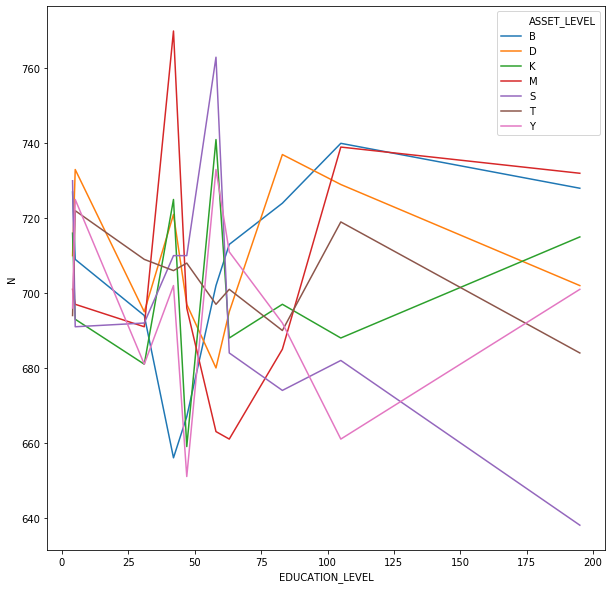

In [84]:
dfi_ass_edu=dfi.groupby(by=['ASSET_LEVEL','EDUCATION_LEVEL','Y/N']).EDUCATION_LEVEL.count()
dfi_ass_edu=dfi_ass_edu.unstack()
#dfi_ass_edu.index.get_level_values('EDUCATION_LEVEL')
plt.figure(figsize=(10,10))
sns.lineplot(x=dfi_ass_edu.index.get_level_values('EDUCATION_LEVEL'),y=dfi_ass_edu['N'],hue=dfi_ass_edu.index.get_level_values('ASSET_LEVEL'))

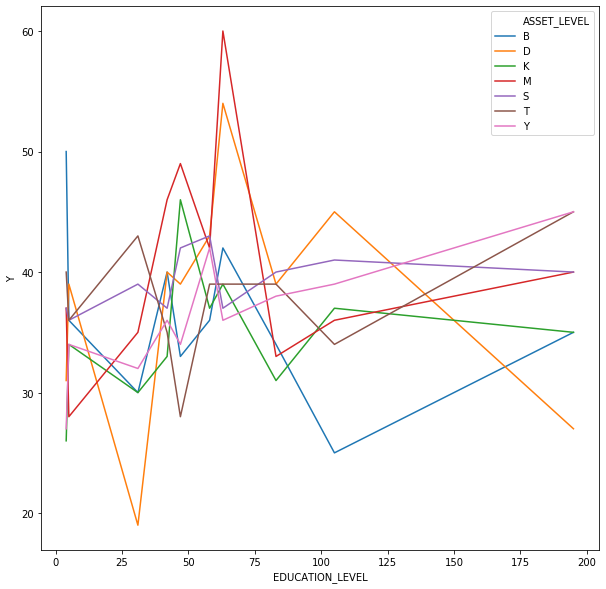

In [85]:
plt.figure(figsize=(10,10))
sns.lineplot(x=dfi_ass_edu.index.get_level_values('EDUCATION_LEVEL'),y=dfi_ass_edu['Y'],hue=dfi_ass_edu.index.get_level_values('ASSET_LEVEL'))

Asset level with M and education level in the range of 50 and 75 accept the product the most, followed by D asset level in the same range of education level.

<function matplotlib.pyplot.show(*args, **kw)>

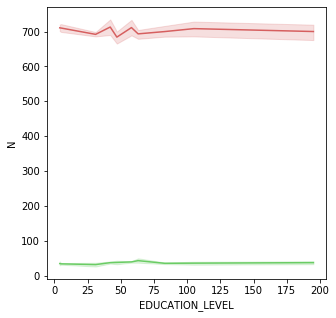

In [20]:
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot(x=dfi_ass_edu.index.get_level_values('EDUCATION_LEVEL'),y=dfi_ass_edu['Y'],color='g')
sns.lineplot(x=dfi_ass_edu.index.get_level_values('EDUCATION_LEVEL'),y=dfi_ass_edu['N'],color='r')
plt.show


Looks like people with education level between 50 and 75 readily to accept the product compared to other levels.

<Figure size 720x720 with 0 Axes>

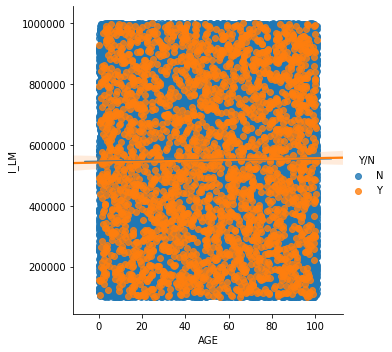

In [90]:
plt.figure(figsize=(10,10))
sns.lmplot(x='AGE',y='I_LM',hue='Y/N',data=dfi,x_jitter=True,y_jitter=True)

There is a slight relationship with the age and current balance. Although most of the selected candidates have the current balance in the range of 500,000, people who chose the product tend to have a higher balance than those who rejected the product.

F_S
1     552868.751555
2     559713.224978
3     550895.139025
4     549080.573181
5     548773.860047
6     545545.172757
7     545251.902181
8     555402.575943
9     546704.463518
10    548052.685039
11    547470.651515
Name: I_LM, dtype: float64

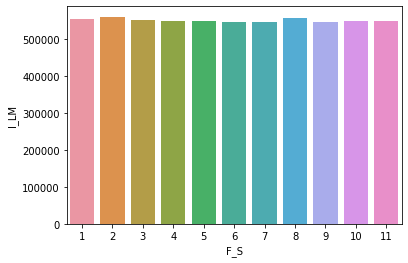

In [91]:
# To check relationship between current balance and the number of family members
dfi.F_S.unique()
dfi.groupby(by='F_S').I_LM.mean()
sns.barplot(x=dfi.groupby(by='F_S').I_LM.mean().index,y=dfi.groupby(by='F_S').I_LM.mean())
dfi.groupby(by='F_S').I_LM.mean()



Current balance higher for candidates who have a family size of 2 or 8.

In [92]:
#account balances for 19 months , including current balance and last 18 months balance
def calsum(x):
    sumacbal=x['I_LM']
    for col in ['A1_LM', 'A2_LM', 'A3_LM', 'A4_LM', 'A5_LM', 'A6_LM', 'A7_LM', 'A8_LM', 'A9_LM','A10_LM', 'A11_LM', 'A12_LM', 'A13_LM', 'A14_LM', 'A15_LM', 'A16_LM','A17_LM', 'A18_LM']:
        sumacbal+= x[col]
    return sumacbal

dfi['acbaltotal']=dfi.apply(lambda x: calsum(x),axis=1)


N    49154
Y     2624
Name: Y/N, dtype: int64
Mean of account balances -  Y/N
N    2.891449e+06
Y    2.890576e+06
Name: acbaltotal, dtype: float64
Sum of account balances -  Y/N
N    1.421263e+11
Y    7.584872e+09
Name: acbaltotal, dtype: float64
Mean of current account balances -  Y/N
N    549981.867885
Y    549239.263338
Name: I_LM, dtype: float64


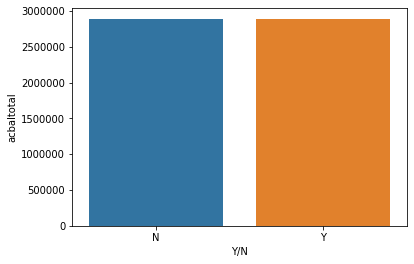

In [93]:
#dfi.groupby(by='ASSET_LEVEL').acbaltotal.mean()
#sns.barplot(x=dfi.groupby(by='ASSET_LEVEL').acbaltotal.mean().index,y=dfi.groupby(by='ASSET_LEVEL').acbaltotal.mean())
#couldnt find any relationship with total account bal mean with asset level. I dont think this data is properly collected??
#sns.scatterplot(x=dfi.index,y=dfi.acbaltotal,hue=dfi['Y/N'])#dint get anything
sns.barplot(x=dfi.groupby(by='Y/N').acbaltotal.mean().index,y=dfi.groupby(by='Y/N').acbaltotal.mean())
print(dfi['Y/N'].value_counts())
print('Mean of account balances - ',dfi.groupby(by='Y/N').acbaltotal.mean())
print('Sum of account balances - ',dfi.groupby(by='Y/N').acbaltotal.sum())
print('Mean of current account balances - ',dfi.groupby(by='Y/N').I_LM.mean())

Looks like the mean of total account balances are similar for Y and N cases.But considering the number of Y and N cases in the dataset, N cases are more. Which means, People who opt Y are having good total account balances. 
Count of observations with Y- 2624
Count of observations with N- 49154
Only 5 percent of account of account holders chose to go with the product.But the mean of balance is very close to N values.
Similar insight from the current account balance.

In [95]:
dfi_age_acbal=dfi.groupby(by=['age_binned','Y/N']).acbaltotal.mean()
dfi_age_acbal

age_binned  Y/N
young       N      2.888911e+06
            Y      2.886878e+06
middle      N      2.891201e+06
            Y      2.865932e+06
elder       N      2.891942e+06
            Y      2.904314e+06
oldest      N      2.894612e+06
            Y      2.908122e+06
Name: acbaltotal, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

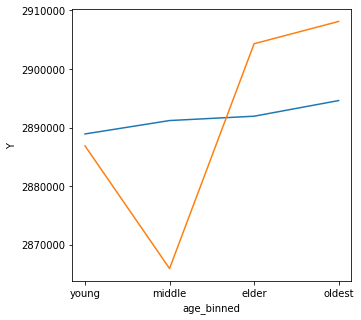

In [96]:
dfi_age_acbal=dfi_age_acbal.unstack()
fig,ax = plt.subplots(figsize=(5,5))
ax=sns.lineplot(x=dfi_age_acbal.index,y=dfi_age_acbal['N'])
ax=sns.lineplot(x=dfi_age_acbal.index,y=dfi_age_acbal['Y'])
#plt.xlabel(xlabel="age group")
#plt.ylabel(ylabel="mean of account balance")
plt.show

Elderly and old age category account holders with highest account balance tend to choose the product.
Middle aged category of people with far less account balance compared to same age category with high account balance are choosing the product.
Young people with less balance compared to young ones with high balance are choosing the product.


In [97]:
dfi[['RATING_Q1', 'RATING_Q2', 'RATING_Q3', 'RATING_Q4']].describe(include='object')
#Replacing value 'S' for highly active with number 9 for RATING columns
dfi['RATING_Q1']=dfi['RATING_Q1'].apply(lambda x:'9' if x == 'S' else x)
dfi['RATING_Q2']=dfi['RATING_Q2'].apply(lambda x:'9' if x == 'S' else x)
dfi['RATING_Q3']=dfi['RATING_Q3'].apply(lambda x:'9' if x == 'S' else x)
dfi['RATING_Q4']=dfi['RATING_Q4'].apply(lambda x:'9' if x == 'S' else x)


In [98]:
dfi_rating1=dfi.groupby(by=['RATING_Q1','Y/N']).RATING_Q1.count().unstack()
dfi_rating1['yperc']=(dfi_rating1['Y']*100)/(dfi_rating1['Y']+dfi_rating1['N'])
dfi_rating2=dfi.groupby(by=['RATING_Q2','Y/N']).RATING_Q2.count().unstack()
dfi_rating2['yperc']=(dfi_rating2['Y']*100)/(dfi_rating2['Y']+dfi_rating2['N'])
dfi_rating3=dfi.groupby(by=['RATING_Q3','Y/N']).RATING_Q3.count().unstack()
dfi_rating3['yperc']=(dfi_rating3['Y']*100)/(dfi_rating3['Y']+dfi_rating3['N'])
dfi_rating4=dfi.groupby(by=['RATING_Q4','Y/N']).RATING_Q4.count().unstack()
dfi_rating4['yperc']=(dfi_rating4['Y']*100)/(dfi_rating4['Y']+dfi_rating4['N'])
#print(dfi_rating1)
#print(dfi_rating2)
#print(dfi_rating3)
#print(dfi_rating4)
temp=pd.DataFrame({'RATING_Q1':dfi_rating1['yperc'],
                  'RATING_Q2':dfi_rating2['yperc'],
                  'RATING_Q3':dfi_rating3['yperc'],
                   'RATING_Q4':dfi_rating4['yperc']},index=dfi_rating1.index)
temp=np.transpose(temp)
temp

RATING_Q1,0,3,6,9
RATING_Q1,5.209696,4.801976,5.132785,5.126621
RATING_Q2,5.159533,4.770656,5.232153,5.112585
RATING_Q3,5.273228,5.014450,5.164062,4.821115
RATING_Q4,5.340945,4.933982,4.913669,5.088427


<function matplotlib.pyplot.show(*args, **kw)>

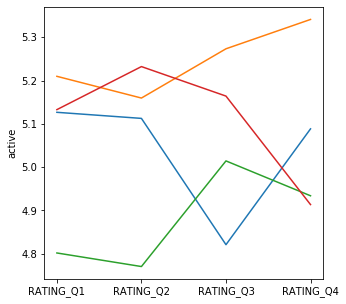

In [99]:
temp=temp.rename(columns={'9':'high',"0":'least',"3":'average',"6":'active'})
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot(x=temp.index,y=temp['high'])
sns.lineplot(x=temp.index,y=temp['least'])
sns.lineplot(x=temp.index,y=temp['average'])
sns.lineplot(x=temp.index,y=temp['active'])
plt.show


Looks like least active and active set of people tends to choose the product.
For more clarity we will sum up the quarter ratings and see whether the total rating has any effect on the decision to choose the product


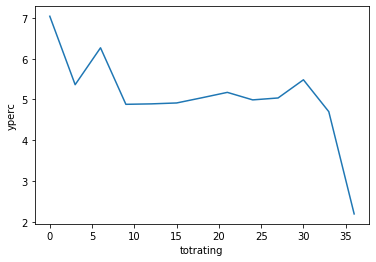

In [100]:
dfi['totrating']=dfi.RATING_Q1.astype(int)+dfi.RATING_Q2.astype(int)+dfi.RATING_Q3.astype(int)+dfi.RATING_Q4.astype(int)
dfi['totrating'].value_counts()
#Looks like the variable can be made as object type
dfi['totrating']=dfi['totrating'].astype('object')
dfi_totrating=dfi.groupby(by=['totrating','Y/N']).totrating.count().unstack()

#sns.lineplot(x=dfi_totrating.index,y=dfi_totrating['Y'])
#sns.lineplot(x=dfi_totrating.index,y=dfi_totrating['N'])
#plt.show
dfi_totrating['yperc']=((dfi_totrating['Y']*100)/(dfi_totrating['Y']+dfi_totrating['N']))
dfi_totrating
sns.lineplot(x=dfi_totrating.index,y=dfi_totrating['yperc'])

Sample has most of the account holders from 15 to 20 total rating range. 
People who are least active(0 total rating), people with total rating of around 30 are also opting to choose the product.

<function matplotlib.pyplot.show(*args, **kw)>

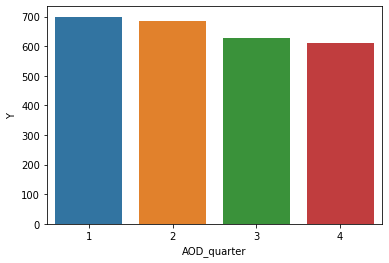

In [101]:
dfi['AOD_quarter']=dfi.index.quarter
dfi['week_day']=dfi.index.weekday


dfi.groupby(by=['week_day','Y/N']).week_day.count().unstack()
sns.barplot(x=dfi.groupby(by=['week_day','Y/N']).week_day.count().unstack().index,y=dfi.groupby(by=['week_day','Y/N']).week_day.count().unstack()['Y'])
#account opening day as Monday, has given most of the Y cases.
dfi.groupby(by=['AOD_quarter','Y/N']).AOD_quarter.count().unstack()
sns.barplot(x=dfi.groupby(by=['AOD_quarter','Y/N']).AOD_quarter.count().unstack().index,y=dfi.groupby(by=['AOD_quarter','Y/N']).AOD_quarter.count().unstack()['Y'])
plt.show


Account opened in first two quarters are choosing to go with the product.They might be people with more of investing mentality?Or may be business could answer this.

In [102]:
#feature transformations. 
df['acbaltotal']=df.apply(lambda x: calsum(x),axis=1)
df['RATING_Q1']=df['RATING_Q1'].apply(lambda x:'9' if x == 'S' else x)
df['RATING_Q2']=df['RATING_Q2'].apply(lambda x:'9' if x == 'S' else x)
df['RATING_Q3']=df['RATING_Q3'].apply(lambda x:'9' if x == 'S' else x)
df['RATING_Q4']=df['RATING_Q4'].apply(lambda x:'9' if x == 'S' else x)
df['totrating']=df.RATING_Q1.astype(float)+df.RATING_Q2.astype(float)+df.RATING_Q3.astype(float)+df.RATING_Q4.astype(float)
#Looks like the variable can be made as object type
df['totrating']=df['totrating'].astype('object')
df['AOD_quarter']=df.index.quarter
df['week_day']=df.index.weekday


In [103]:
df.age_binned=df.age_binned.astype('object')
dfbkp=df.copy()


In [113]:
### As the year can casuse data leakage, splitting the dataset to training and validation sets before any further processing. 
splitratio=0.8
#taking PPROXIMATE VALUE
XYtrain=df[:-35704]
XYtest=df[-35704:]
Ytrain=XYtrain['Y/N']
Ytest=XYtest['Y/N']
Xtrain=XYtrain.drop(columns=['Y/N'])
Xtest=XYtest.drop(columns=['Y/N'])

contcol=[col for col in df.columns if df[col].dtypes in ['int64','float64']]
catcol=[col for col in df.columns if df[col].dtypes =='object']
catcol.remove('Y/N')


Xtraincat=Xtrain[catcol]
Xtraincont=Xtrain[contcol]
Xtestcat=Xtest[catcol]
Xtestcont=Xtest[contcol]

In [116]:
###***HANDLE MISSING VALUES***###

#to see the difference btw mean and median.for identifying stratergy in imputer
cont=df.describe()
cont=cont.append(pd.Series(data=df.median(skipna=True,numeric_only=True),name='median'))

cont_imputer=SimpleImputer(strategy='median')
Xtraincont_imputed=pd.DataFrame(cont_imputer.fit_transform(Xtraincont))
Xtraincont_imputed.columns=Xtraincont.columns
Xtestcont_imputed=pd.DataFrame(cont_imputer.transform(Xtestcont))
Xtestcont_imputed.columns=Xtestcont.columns

cat_imputer=SimpleImputer(strategy='most_frequent')
Xtraincat_imputed=pd.DataFrame(cat_imputer.fit_transform(Xtraincat))
Xtraincat_imputed.columns=Xtraincat.columns
Xtestcat_imputed=pd.DataFrame(cat_imputer.transform(Xtestcat))
Xtestcat_imputed.columns=Xtestcat.columns



In [117]:
#do preprocessing
#Using LabelEncoder as the categorical variables are ordinal

l_encoder=LabelEncoder()
for col in catcol:
    Xtraincat_imputed[col]=l_encoder.fit_transform(Xtraincat_imputed[col])
    Xtestcat_imputed[col]=l_encoder.transform(Xtestcat_imputed[col])

#concatenating before standardizing as we did LabelEncoding
Xtrain_encoded=Xtraincont_imputed.join(Xtraincat_imputed,how='inner')
Xtest_encoded=Xtestcont_imputed.join(Xtestcat_imputed,how='inner')

#Scaling cont data using MinMaxScaler
contscaler=MinMaxScaler()
Xtrain=pd.DataFrame(contscaler.fit_transform(Xtrain_encoded))
Xtrain.columns=Xtrain_encoded.columns
Xtest=pd.DataFrame(contscaler.transform(Xtest_encoded))
Xtest.columns=Xtest_encoded.columns



In [119]:
def xgb_model(estimators,l_rates,Xtrain,Ytrain,Xtest,Ytest):
    for n_est in estimators:
        for l_rate in l_rates:
            model=XGBClassifier(n_estimators=n_est,learning_rate=l_rate,verbose=False)
            model.fit(Xtrain,Ytrain,early_stopping_rounds=5,eval_set=[(Xtest,Ytest)],eval_metric='auc')
            predicted_val=model.predict(Xtest)
##validation
            print("estimator {},lrate {},confusion matrix {}".format(n_est,l_rate,confusion_matrix(Ytest,predicted_val)))
            print(classification_report(Ytest,predicted_val))
    return model

In [120]:
#SMOTE technique: Synthetic Minority Oversampling Technique
sm=SMOTE(random_state=30)
Xtrain,Ytrain=sm.fit_sample(Xtrain,Ytrain)

model_product=xgb_model([1500],[0.001],Xtrain,Ytrain,Xtest,Ytest)

[0]	validation_0-auc:0.501264
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.501264
[2]	validation_0-auc:0.501264
[3]	validation_0-auc:0.501264
[4]	validation_0-auc:0.501264
[5]	validation_0-auc:0.501264
Stopping. Best iteration:
[0]	validation_0-auc:0.501264

estimator 1500,lrate 0.001,confusion matrix [[15024 18817]
 [  825  1038]]
              precision    recall  f1-score   support

           N       0.95      0.44      0.60     33841
           Y       0.05      0.56      0.10      1863

    accuracy                           0.45     35704
   macro avg       0.50      0.50      0.35     35704
weighted avg       0.90      0.45      0.58     35704



In [121]:
model_product=xgb_model([1000,1500],[0.01,.001,0.1],Xtrain,Ytrain,Xtest,Ytest)

[0]	validation_0-auc:0.501264
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.503864
[2]	validation_0-auc:0.501766
[3]	validation_0-auc:0.503864
[4]	validation_0-auc:0.502552
[5]	validation_0-auc:0.501741
[6]	validation_0-auc:0.500138
Stopping. Best iteration:
[1]	validation_0-auc:0.503864

estimator 1000,lrate 0.01,confusion matrix [[20340 13501]
 [ 1120   743]]
              precision    recall  f1-score   support

           N       0.95      0.60      0.74     33841
           Y       0.05      0.40      0.09      1863

    accuracy                           0.59     35704
   macro avg       0.50      0.50      0.41     35704
weighted avg       0.90      0.59      0.70     35704

[0]	validation_0-auc:0.501264
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.501264
[2]	validation_0-auc:0.501264
[3]	validation_0-auc:0.501264
[4]	validation_0-auc:0.501264
[5]	validation_0-auc:0.501264
Stopping. Best iteration:


The model that gives least recall value is ideal here as we do not want to loose any customer who will choose to buy the product. Lease recall gives least false negative values.